In [1]:
# allows to import own functions
import sys, os, re
root_project = re.findall(r'(^\S*TFM-master)', os.getcwd())[0]
sys.path.append(root_project)

from src.utils.help_func import make_train_val_test

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import json
import datetime
import seaborn as sns
import csv
sns.set()
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import initializers

import os
import time

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8063280899645260005,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 896005796774823922
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5797537376
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1741176147173442102
 physical_device_desc: "device: 0, name: GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2066293855097267238
 physical_device_desc: "device: XLA_GPU device"]

In [5]:
df = pd.read_pickle(f'{root_project}/data/processed/features_model_rev2.pickle')
print(df.shape)
df.head()

(260000, 23)


,initial_country,idx_country,R0,Tc,Tr,omega,inf_power_1,inf_power_2,gradient_inf,mort_power_1,...,limit_deaths,n_closed,react_time,total_infected,total_death,total_recovered,betweenness,degree,closeness,country_pop
0,LBN,106,9.490802,2.214174,21.014286,0.069029,2918.571429,114.077951,"[182.0, 218.5, 306.5, 430.5, 604.0, 848.0, 119...",0.007146,...,72,6,23,7.509993e+09,519150500.0,7.521256e+09,0.001057,0.270270,0.460581,6848925.0
1,KIR,99,3.161672,6.111805,19.323523,0.012080,9342.214286,15.305328,"[1133.0, 5880.5, 6536.5, 7265.0, 8072.0, 8969....",0.003708,...,872,2,2,5.277990e+09,63875908.0,5.290389e+09,0.000956,0.036036,0.391534,115847.0
2,MOZ,129,16.439975,1.263448,20.771054,0.046275,80454.071429,2297.546954,"[585.0, 803.5, 1401.0, 2441.5, 4255.5, 7417.0,...",0.002847,...,192,0,22,5.556171e+09,257680389.0,5.569051e+09,0.000059,0.054054,0.382759,29495962.0
3,ERI,58,2.141326,1.149404,2.461249,0.014779,5593.642857,196.917492,"[140.0, 173.0, 253.5, 370.5, 542.0, 793.0, 115...",0.006883,...,511,9,28,4.726188e+09,69844180.0,4.726333e+09,0.000007,0.049550,0.368159,3213972.0
4,VCT,174,9.327237,1.192357,11.121400,0.058201,9890.000000,286.924893,"[346.0, 474.0, 821.5, 1413.5, 2399.0, 3983.5, ...",0.013340,...,958,18,20,3.816704e+09,222148991.0,3.817110e+09,0.000035,0.040541,0.312236,110210.0


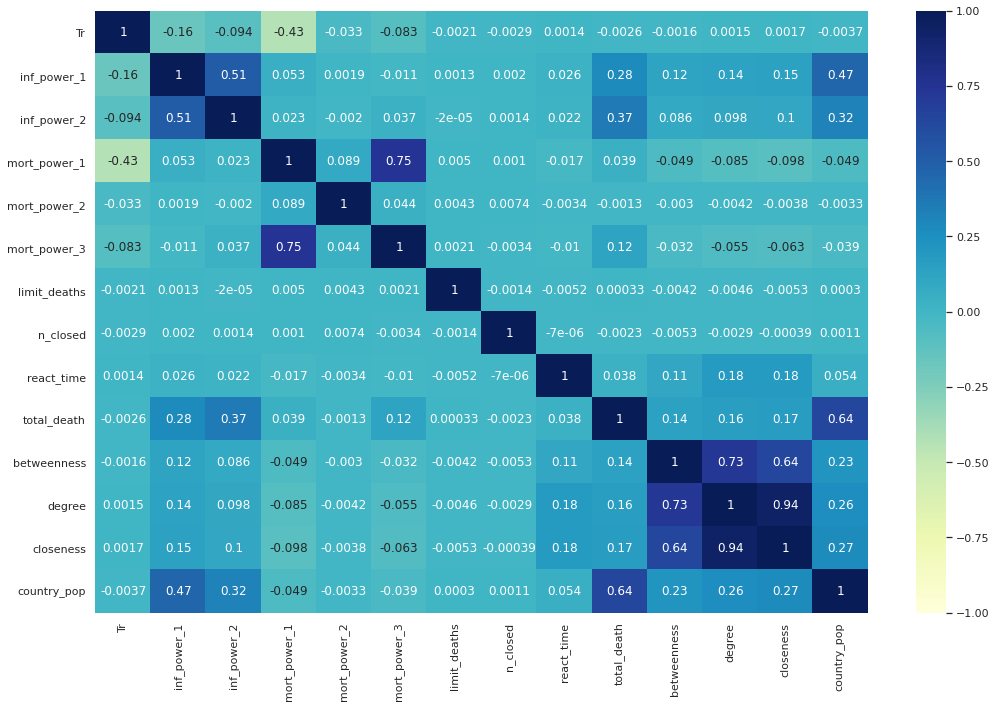

In [6]:
features = ['Tr', 'inf_power_1', 'inf_power_2', 'mort_power_1', 'mort_power_2', 'mort_power_3', 'limit_deaths',
           'n_closed', 'react_time','total_death', 'betweenness', 'degree', 'closeness', 'country_pop']

df = df[features]

corr_matrix = df.corr()
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.heatmap(corr_matrix, vmax=1, vmin=-1, annot=True, cmap="YlGnBu", ax=ax)
plt.tight_layout()

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = make_train_val_test(df)

size_data = int(len(X_train) / 1000)
num_features= len(X_train.columns)

Train set: (156000, 13)
Validation set: (52000, 13)
Test set: (52000, 13)


In [8]:
num_columns = X_train.columns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns].astype(np.float64))
X_val_scaled = scaler.transform(X_val[num_columns].astype(np.float64))
X_test_scaled = scaler.transform(X_test[num_columns].astype(np.float64))

# oh = OneHotEncoder(handle_unknown='ignore')
# X_train_scaled = np.hstack((X_train_scaled, oh.fit_transform(X_train[cat_columns]).toarray()))
# X_test_scaled = np.hstack((X_test_scaled, oh.transform(X_test[cat_columns]).toarray()))

# scaler = StandardScaler()
# y_train = scaler.fit_transform(np.expand_dims(y_train.astype(np.float64),axis=1))
# y_test = scaler.transform(np.expand_dims(y_test.astype(np.float64),axis=1))

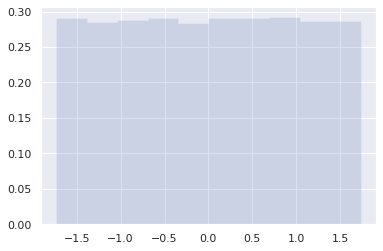

In [9]:
fig, ax = plt.subplots(1, 1)
ax.hist(X_train_scaled[:,0], density=True, histtype='stepfilled', alpha=0.2)
plt.show()

In [10]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [11]:
# import shutil
# shutil.rmtree('/content/drive/My Drive/TFM/archivos_colab/my_logs')

In [12]:
# root_logdir_tensorboard = '/content/drive/My Drive/TFM/archivos_colab/my_logs'
# root_logdir_checkpoints = '/content/drive/My Drive/TFM/archivos_colab/checkpoints'

root_logdir_tensorboard = f"{root_project}/models/my_logs"
root_logdir_checkpoints = f"{root_project}/models/checkpoints"

In [13]:
# dense_layers = [4, 5, 6]
# layer_sizes = [90,100,110]


dense_layers = [5]
layer_sizes = [80]

revision = '11'

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        time.sleep(30)
        run_time = time.strftime("run_%d_%m_%Y-%H_%M_%S")
        NAME = f"{dense_layer}-layers-{layer_size}-nodes-{size_data}k-samples-{num_features}-feat-rev{revision}-{run_time}"
        print(NAME)
        model = Sequential()
        inputs = Input(X_train_scaled.shape[1:])
        
        for l in range(dense_layer-1):
            model.add(Dense(layer_size, activation='selu', kernel_initializer='lecun_normal'))
        
        model.add(Dense(1))
        
        tensorboard_cb = keras.callbacks.TensorBoard(f"{root_logdir_tensorboard}/{NAME}")
        early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
        checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=f"{root_logdir_checkpoints}/{NAME}",
                                                       save_best_only=True, verbose=1)

        # model.compile(optimizer=Nadam(), loss='mean_squared_error', metrics=['mean_absolute_error'])
        model.compile(optimizer=Nadam(), loss='mean_squared_error',
                      metrics=['mean_absolute_error', coeff_determination])

        
        history = model.fit(X_train_scaled, y_train, epochs=500, verbose=0,
                            validation_data=(X_test_scaled, y_test),
                           callbacks=[tensorboard_cb, early_stopping_cb, checkpoint_cb])

        score_train = model.evaluate(X_train_scaled, y_train, verbose=0)
        score_test = model.evaluate(X_val_scaled, y_val, verbose=0)
        
        to_csv = [NAME, score_test[0], score_test[1], score_test[2]]
        
        with open(f"{root_project}/models/result_models.csv", mode='w') as results_file:
            model_writer = csv.writer(results_file, delimiter=',')
            model_writer.writerow(to_csv)
        
        print('Train score:', score_train[0])
        print('Train MAE:', score_train[1])
        print('Train r-squared:', score_train[2])
        print('Test score:', score_test[0])
        print('Test MAE:', score_test[1])
        print('Test r-squared:', score_test[2])
        print('========')

5-layers-80-nodes-156k-samples-13-feat-rev11-run_23_08_2020-13_24_39

Epoch 00001: val_loss improved from inf to 455680964165632.00000, saving model to /disks/hdd2T/Drive/TFM-master/models/checkpoints/5-layers-80-nodes-156k-samples-13-feat-rev11-run_23_08_2020-13_24_39
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /disks/hdd2T/Drive/TFM-master/models/checkpoints/5-layers-80-nodes-156k-samples-13-feat-rev11-run_23_08_2020-13_24_39/assets

Epoch 00002: val_loss improved from 455680964165632.00000 to 336924145352704.00000, saving model to /disks/hdd2T/Drive/TFM-master/models/checkpoints/5-layers-80-nodes-156k-samples-13-feat-rev11-run_23_08_2020-13_24_39
INFO:tensorflow:Assets written to: /disks/hdd2T/Drive/TFM-master/models/checkpoints/5-layers-80-nodes-156k-samples-13-feat-rev11-run_23_08_2020-13_24_39/assets

Epoch 00003: val_loss improved from 336924145352704.00000 to 298354466619392.00000, saving model to /disks/hd


Epoch 00026: val_loss improved from 257105634263040.00000 to 255700693417984.00000, saving model to /disks/hdd2T/Drive/TFM-master/models/checkpoints/5-layers-80-nodes-156k-samples-13-feat-rev11-run_23_08_2020-13_24_39
INFO:tensorflow:Assets written to: /disks/hdd2T/Drive/TFM-master/models/checkpoints/5-layers-80-nodes-156k-samples-13-feat-rev11-run_23_08_2020-13_24_39/assets

Epoch 00027: val_loss did not improve from 255700693417984.00000

Epoch 00028: val_loss improved from 255700693417984.00000 to 254263439654912.00000, saving model to /disks/hdd2T/Drive/TFM-master/models/checkpoints/5-layers-80-nodes-156k-samples-13-feat-rev11-run_23_08_2020-13_24_39
INFO:tensorflow:Assets written to: /disks/hdd2T/Drive/TFM-master/models/checkpoints/5-layers-80-nodes-156k-samples-13-feat-rev11-run_23_08_2020-13_24_39/assets

Epoch 00029: val_loss did not improve from 254263439654912.00000

Epoch 00030: val_loss improved from 254263439654912.00000 to 252755906134016.00000, saving model to /disks/hd


Epoch 00070: val_loss improved from 236162148990976.00000 to 235902135697408.00000, saving model to /disks/hdd2T/Drive/TFM-master/models/checkpoints/5-layers-80-nodes-156k-samples-13-feat-rev11-run_23_08_2020-13_24_39
INFO:tensorflow:Assets written to: /disks/hdd2T/Drive/TFM-master/models/checkpoints/5-layers-80-nodes-156k-samples-13-feat-rev11-run_23_08_2020-13_24_39/assets

Epoch 00071: val_loss improved from 235902135697408.00000 to 234855304527872.00000, saving model to /disks/hdd2T/Drive/TFM-master/models/checkpoints/5-layers-80-nodes-156k-samples-13-feat-rev11-run_23_08_2020-13_24_39
INFO:tensorflow:Assets written to: /disks/hdd2T/Drive/TFM-master/models/checkpoints/5-layers-80-nodes-156k-samples-13-feat-rev11-run_23_08_2020-13_24_39/assets

Epoch 00072: val_loss improved from 234855304527872.00000 to 234301002088448.00000, saving model to /disks/hdd2T/Drive/TFM-master/models/checkpoints/5-layers-80-nodes-156k-samples-13-feat-rev11-run_23_08_2020-13_24_39
INFO:tensorflow:Assets 


Epoch 00119: val_loss improved from 207493208735744.00000 to 201285353603072.00000, saving model to /disks/hdd2T/Drive/TFM-master/models/checkpoints/5-layers-80-nodes-156k-samples-13-feat-rev11-run_23_08_2020-13_24_39
INFO:tensorflow:Assets written to: /disks/hdd2T/Drive/TFM-master/models/checkpoints/5-layers-80-nodes-156k-samples-13-feat-rev11-run_23_08_2020-13_24_39/assets

Epoch 00120: val_loss did not improve from 201285353603072.00000

Epoch 00121: val_loss did not improve from 201285353603072.00000

Epoch 00122: val_loss improved from 201285353603072.00000 to 199632277733376.00000, saving model to /disks/hdd2T/Drive/TFM-master/models/checkpoints/5-layers-80-nodes-156k-samples-13-feat-rev11-run_23_08_2020-13_24_39
INFO:tensorflow:Assets written to: /disks/hdd2T/Drive/TFM-master/models/checkpoints/5-layers-80-nodes-156k-samples-13-feat-rev11-run_23_08_2020-13_24_39/assets

Epoch 00123: val_loss did not improve from 199632277733376.00000

Epoch 00124: val_loss did not improve from 

In [25]:
# model.save(f'/content/drive/My Drive/TFM/archivos_colab/models/{NAME}.h5')

In [26]:
# model = load_model('/disks/hdd2T/Drive/TFM_AGM/models/checkpoints/5-layers-90-nodes-100k-samples-rev9-run_22_08_2020-10_02_04',
#                    custom_objects={'coeff_determination':coeff_determination})
# score_train = model.evaluate(X_train_scaled, y_train, verbose=0)
# score_test = model.evaluate(X_test_scaled, y_test, verbose=0)

# print('Train score:', score_train[0])
# print('Train MAE:', score_train[1])
# print('Train r-squared:', score_train[2])
# print('Test score:', score_test[0])
# print('Test MAE:', score_test[1])
# print('Test r-squared:', score_test[2])

In [27]:
X_err = X_test.copy()
X_err['predicted'] = model.predict(X_test_scaled)
X_err['real'] = y_test
X_err['error'] = X_err['real'] - X_err['predicted']
X_err['abs_error'] = np.abs(X_err['error'])
X_err

,Tr,inf_power_1,inf_power_2,mort_power_1,mort_power_2,mort_power_3,limit_deaths,n_closed,react_time,betweenness,degree,closeness,country_pop,predicted,real,error,abs_error
91829,6.186454,8.110971e+04,98.999098,0.008239,0.042628,0.010232,52,10,1,0.000000,0.009009,0.347418,1136191.0,1.893556e+06,12172.0,-1.881384e+06,1.881384e+06
97140,7.832373,1.400379e+04,362.272251,0.153219,0.434127,0.237030,224,17,22,0.000000,0.031532,0.399281,196130.0,4.112262e+05,50502.0,-3.607242e+05,3.607242e+05
85185,20.774082,2.000150e+04,274.198413,0.002000,0.001474,0.015052,256,2,19,0.004549,0.171171,0.470339,30809762.0,1.893556e+06,700354.0,-1.193202e+06,1.193202e+06
14363,11.613674,3.972929e+03,54.001733,0.018788,0.033538,0.042978,237,8,23,0.000058,0.027027,0.356340,56225.0,1.893556e+06,2723.0,-1.890834e+06,1.890834e+06
9420,15.773816,6.345148e+05,5951.845588,0.005184,0.006321,0.028828,614,7,24,0.002026,0.360360,0.517483,8883800.0,5.275155e+05,370440.0,-1.570755e+05,1.570755e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5429,9.481070,2.718571e+02,25.481481,0.026537,0.029360,0.073295,898,5,1,0.000209,0.252252,0.463466,19473936.0,1.612985e+06,1884816.0,2.718308e+05,2.718308e+05
44776,4.900278,4.005286e+03,10.805616,0.060277,0.675595,0.066642,400,5,4,0.000058,0.027027,0.356340,56225.0,1.893556e+06,3836.0,-1.889720e+06,1.889720e+06
46843,20.532422,1.160786e+03,21.157962,0.005477,0.005359,0.026433,159,1,25,0.005802,0.090090,0.416510,165768.0,1.893556e+06,5701.0,-1.887856e+06,1.887856e+06
125006,10.869260,3.186017e+06,293032.039474,0.018136,0.018162,0.114027,568,3,20,0.022482,0.396396,0.536232,51635256.0,1.028729e+07,12682232.0,2.394940e+06,2.394940e+06


In [28]:
X.describe()

NameError: name 'X' is not defined

In [ ]:
X_err_sorted = X_err.sort_values(by='abs_error', ascending=False).iloc[:200]
X_err_sorted.describe()

Para ver donde estoy cometiendo los errores

In [ ]:
for column in X.columns:
  fig, ax = plt.subplots(1, 1, figsize = (15,8))
  sns.distplot(X[column], hist=True, color='skyblue', label='Original', ax=ax)
  sns.distplot(X_err_sorted[column], hist=True, color='red', label='Errors', ax=ax)
  ax.set(title=column)
  plt.legend()
  plt.show()

In [ ]:
y_predicted = model.predict(X_test_scaled).flatten()
df_predicted = pd.DataFrame({'Actual': y_test, 'Predicted': y_predicted})

In [ ]:
df_predicted.sample(100).plot(kind='barh',figsize=(15,50))
plt.show()